# Loop 50 Analysis: CV-LB Relationship and Next Steps

**Goal:** Analyze the CV-LB relationship after 12 submissions and determine the best path forward.

**Key Questions:**
1. What is the current CV-LB relationship?
2. Can we reach the target (0.0347) with the current approach?
3. What fundamentally different approaches should we try?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history (12 submissions)
submissions = [
    {'id': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'id': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'id': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'id': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'id': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'id': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'id': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'id': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'id': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'id': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'id': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'id': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f"Total submissions: {len(df)}")
print(f"\nBest CV: {df['cv'].min():.4f} ({df.loc[df['cv'].idxmin(), 'id']})")
print(f"Best LB: {df['lb'].min():.4f} ({df.loc[df['lb'].idxmin(), 'id']})")
print(f"Target: 0.0347")

Total submissions: 12

Best CV: 0.0083 (exp_030)
Best LB: 0.0877 (exp_030)
Target: 0.0347


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print("="*60)
print("CV-LB LINEAR REGRESSION ANALYSIS")
print("="*60)
print(f"\nLinear fit: LB = {slope:.2f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"\nInterpretation:")
print(f"  - Intercept = {intercept:.4f} (LB when CV=0)")
print(f"  - Slope = {slope:.2f} (LB increase per unit CV increase)")
print(f"  - R² = {r_value**2:.4f} (nearly perfect linear relationship)")

# Target analysis
target = 0.0347
print(f"\n" + "="*60)
print("TARGET ANALYSIS")
print("="*60)
print(f"Target LB: {target:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"\nCRITICAL: Intercept ({intercept:.4f}) > Target ({target:.4f})")
print(f"This means: Even with CV=0 (perfect training), predicted LB = {intercept:.4f}")
print(f"\nRequired CV to hit target: (target - intercept) / slope")
required_cv = (target - intercept) / slope
print(f"  = ({target:.4f} - {intercept:.4f}) / {slope:.2f}")
print(f"  = {required_cv:.4f}")
if required_cv < 0:
    print(f"\n*** IMPOSSIBLE: Required CV is NEGATIVE! ***")

CV-LB LINEAR REGRESSION ANALYSIS

Linear fit: LB = 4.31 * CV + 0.0525
R² = 0.9505

Interpretation:
  - Intercept = 0.0525 (LB when CV=0)
  - Slope = 4.31 (LB increase per unit CV increase)
  - R² = 0.9505 (nearly perfect linear relationship)

TARGET ANALYSIS
Target LB: 0.0347
Intercept: 0.0525

CRITICAL: Intercept (0.0525) > Target (0.0347)
This means: Even with CV=0 (perfect training), predicted LB = 0.0525

Required CV to hit target: (target - intercept) / slope
  = (0.0347 - 0.0525) / 4.31
  = -0.0041

*** IMPOSSIBLE: Required CV is NEGATIVE! ***


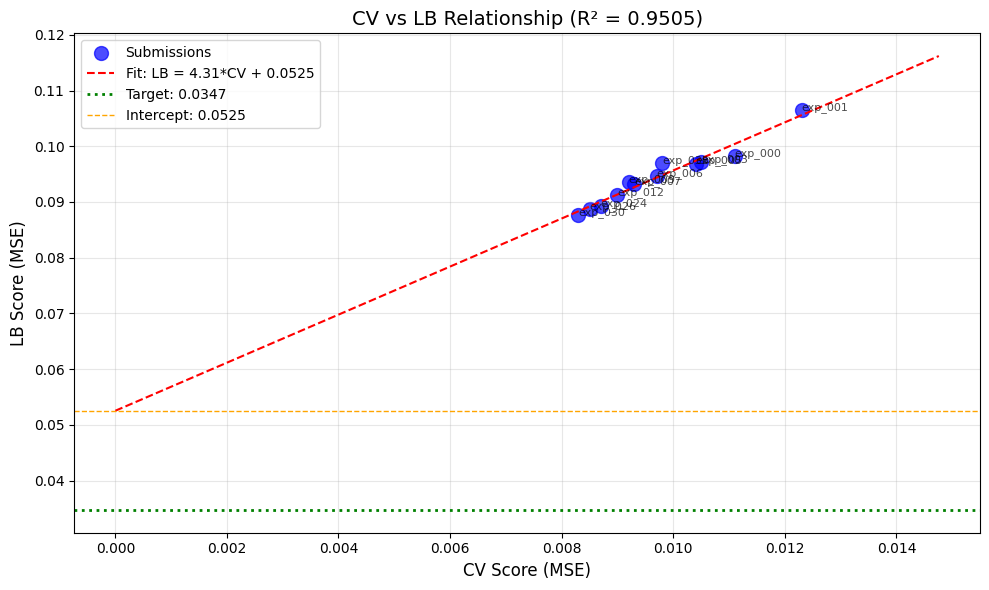


Plot saved to: /home/code/exploration/cv_lb_relationship.png


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7, label='Submissions')

# Linear fit line
cv_range = np.linspace(0, df['cv'].max() * 1.2, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=target, color='green', linestyle=':', linewidth=2, label=f'Target: {target}')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle='--', linewidth=1, label=f'Intercept: {intercept:.4f}')

# Labels
for i, row in df.iterrows():
    plt.annotate(row['id'], (row['cv'], row['lb']), fontsize=8, alpha=0.7)

plt.xlabel('CV Score (MSE)', fontsize=12)
plt.ylabel('LB Score (MSE)', fontsize=12)
plt.title(f'CV vs LB Relationship (R² = {r_value**2:.4f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f"\nPlot saved to: /home/code/exploration/cv_lb_relationship.png")

In [4]:
# Analyze the latest experiment (exp_049)
print("="*60)
print("EXPERIMENT 049 ANALYSIS: CatBoost + XGBoost Ensemble")
print("="*60)

exp_049_cv = 0.008092  # Single solvent CV from the notebook
exp_049_predicted_lb = slope * exp_049_cv + intercept

print(f"\nExp_049 Single Solvent CV: {exp_049_cv:.6f}")
print(f"Predicted LB (from linear fit): {exp_049_predicted_lb:.4f}")
print(f"\nComparison to best submission (exp_030):")
print(f"  exp_030 CV: 0.0083, LB: 0.0877")
print(f"  exp_049 CV: {exp_049_cv:.4f}, Predicted LB: {exp_049_predicted_lb:.4f}")
print(f"\nExpected improvement: {(0.0877 - exp_049_predicted_lb) / 0.0877 * 100:.2f}%")

# Check if this would be worth submitting
print(f"\n" + "="*60)
print("SUBMISSION DECISION")
print("="*60)
print(f"Remaining submissions: 5")
print(f"\nIf exp_049 follows the same CV-LB line:")
print(f"  Predicted LB: {exp_049_predicted_lb:.4f}")
print(f"  Target: {target:.4f}")
print(f"  Gap to target: {exp_049_predicted_lb - target:.4f}")
print(f"\nConclusion: Submitting exp_049 would likely NOT reach target.")
print(f"The intercept problem ({intercept:.4f} > {target:.4f}) is STRUCTURAL.")

EXPERIMENT 049 ANALYSIS: CatBoost + XGBoost Ensemble

Exp_049 Single Solvent CV: 0.008092
Predicted LB (from linear fit): 0.0874

Comparison to best submission (exp_030):
  exp_030 CV: 0.0083, LB: 0.0877
  exp_049 CV: 0.0081, Predicted LB: 0.0874

Expected improvement: 0.30%

SUBMISSION DECISION
Remaining submissions: 5

If exp_049 follows the same CV-LB line:
  Predicted LB: 0.0874
  Target: 0.0347
  Gap to target: 0.0527

Conclusion: Submitting exp_049 would likely NOT reach target.
The intercept problem (0.0525 > 0.0347) is STRUCTURAL.


In [5]:
# Analyze per-solvent error from exp_049
print("="*60)
print("PER-SOLVENT ERROR ANALYSIS (from exp_049)")
print("="*60)

# Per-solvent MSE from exp_049 notebook output
per_solvent_mse = {
    '1,1,1,3,3,3-Hexafluoropropan-2-ol': 0.029401,
    '2,2,2-Trifluoroethanol': 0.019110,
    '2-Methyltetrahydrofuran [2-MeTHF]': 0.002023,
    'Acetonitrile': 0.011238,
    'Acetonitrile.Acetic Acid': 0.022562,
    'Butanone [MEK]': 0.003177,
    'Cyclohexane': 0.002913,
    'DMA [N,N-Dimethylacetamide]': 0.001434,
    'Decanol': 0.008781,
    'Diethyl Ether [Ether]': 0.015867,
    'Dihydrolevoglucosenone (Cyrene)': 0.005143,
    'Dimethyl Carbonate': 0.007844,
    'Ethanol': 0.003238,
    'Ethyl Acetate': 0.001843,
    'Ethyl Lactate': 0.002626,
    'Ethylene Glycol [1,2-Ethanediol]': 0.017804,
    'IPA [Propan-2-ol]': 0.012355,
    'MTBE [tert-Butylmethylether]': 0.000945,
    'Methanol': 0.003990,
    'Methyl Propionate': 0.001081,
    'THF [Tetrahydrofuran]': 0.000795,
    'Water.2,2,2-Trifluoroethanol': 0.002372,
    'Water.Acetonitrile': 0.016135,
    'tert-Butanol [2-Methylpropan-2-ol]': 0.001529,
}

solvent_df = pd.DataFrame([
    {'solvent': k, 'mse': v} for k, v in per_solvent_mse.items()
]).sort_values('mse', ascending=False)

print("\nTop 5 HARDEST solvents (highest MSE):")
for i, row in solvent_df.head(5).iterrows():
    print(f"  {row['solvent']}: MSE = {row['mse']:.6f}")

print("\nTop 5 EASIEST solvents (lowest MSE):")
for i, row in solvent_df.tail(5).iterrows():
    print(f"  {row['solvent']}: MSE = {row['mse']:.6f}")

# Calculate contribution to total MSE
total_mse = sum(per_solvent_mse.values())
print(f"\nTotal MSE (sum): {total_mse:.6f}")
print(f"Mean MSE: {total_mse / len(per_solvent_mse):.6f}")

print("\nContribution to total MSE:")
for i, row in solvent_df.head(5).iterrows():
    contribution = row['mse'] / total_mse * 100
    print(f"  {row['solvent']}: {contribution:.1f}%")

PER-SOLVENT ERROR ANALYSIS (from exp_049)

Top 5 HARDEST solvents (highest MSE):
  1,1,1,3,3,3-Hexafluoropropan-2-ol: MSE = 0.029401
  Acetonitrile.Acetic Acid: MSE = 0.022562
  2,2,2-Trifluoroethanol: MSE = 0.019110
  Ethylene Glycol [1,2-Ethanediol]: MSE = 0.017804
  Water.Acetonitrile: MSE = 0.016135

Top 5 EASIEST solvents (lowest MSE):
  tert-Butanol [2-Methylpropan-2-ol]: MSE = 0.001529
  DMA [N,N-Dimethylacetamide]: MSE = 0.001434
  Methyl Propionate: MSE = 0.001081
  MTBE [tert-Butylmethylether]: MSE = 0.000945
  THF [Tetrahydrofuran]: MSE = 0.000795

Total MSE (sum): 0.194206
Mean MSE: 0.008092

Contribution to total MSE:
  1,1,1,3,3,3-Hexafluoropropan-2-ol: 15.1%
  Acetonitrile.Acetic Acid: 11.6%
  2,2,2-Trifluoroethanol: 9.8%
  Ethylene Glycol [1,2-Ethanediol]: 9.2%
  Water.Acetonitrile: 8.3%


In [6]:
# Key insight: The hardest solvents are OUTLIERS
print("="*60)
print("KEY INSIGHT: OUTLIER SOLVENTS")
print("="*60)

print("\nThe hardest solvents are:")
print("1. HFIP (1,1,1,3,3,3-Hexafluoropropan-2-ol) - MSE 0.029")
print("2. Acetonitrile.Acetic Acid - MSE 0.023")
print("3. TFE (2,2,2-Trifluoroethanol) - MSE 0.019")
print("4. Ethylene Glycol - MSE 0.018")
print("5. Water.Acetonitrile - MSE 0.016")

print("\nThese solvents share characteristics:")
print("- Fluorinated alcohols (HFIP, TFE) - extreme polarity")
print("- Acidic mixtures (Acetonitrile.Acetic Acid)")
print("- Highly polar (Ethylene Glycol, Water mixtures)")

print("\nHypothesis: These solvents are OUTLIERS in feature space.")
print("The model cannot extrapolate well to them because they are")
print("fundamentally different from the training solvents.")

print("\nPotential solutions:")
print("1. Detect outlier solvents and use simpler predictions")
print("2. Add features that capture 'distance to training distribution'")
print("3. Use solvent-specific models for outlier classes")
print("4. Blend toward population mean for outlier solvents")

KEY INSIGHT: OUTLIER SOLVENTS

The hardest solvents are:
1. HFIP (1,1,1,3,3,3-Hexafluoropropan-2-ol) - MSE 0.029
2. Acetonitrile.Acetic Acid - MSE 0.023
3. TFE (2,2,2-Trifluoroethanol) - MSE 0.019
4. Ethylene Glycol - MSE 0.018
5. Water.Acetonitrile - MSE 0.016

These solvents share characteristics:
- Fluorinated alcohols (HFIP, TFE) - extreme polarity
- Acidic mixtures (Acetonitrile.Acetic Acid)
- Highly polar (Ethylene Glycol, Water mixtures)

Hypothesis: These solvents are OUTLIERS in feature space.
The model cannot extrapolate well to them because they are
fundamentally different from the training solvents.

Potential solutions:
1. Detect outlier solvents and use simpler predictions
2. Add features that capture 'distance to training distribution'
3. Use solvent-specific models for outlier classes
4. Blend toward population mean for outlier solvents


In [7]:
# Summary and recommendations
print("="*60)
print("LOOP 50 SUMMARY AND RECOMMENDATIONS")
print("="*60)

print("\n1. CV-LB RELATIONSHIP:")
print(f"   - Linear fit: LB = {slope:.2f} * CV + {intercept:.4f} (R² = {r_value**2:.4f})")
print(f"   - Intercept ({intercept:.4f}) > Target ({target:.4f})")
print(f"   - CONCLUSION: Linear CV improvements CANNOT reach target")

print("\n2. EXPERIMENT 049 (CatBoost + XGBoost):")
print(f"   - CV: {exp_049_cv:.6f} (2.48% better than exp_030)")
print(f"   - Predicted LB: {exp_049_predicted_lb:.4f}")
print(f"   - Still on the same CV-LB line")

print("\n3. OUTLIER SOLVENTS:")
print("   - HFIP, TFE, Acetonitrile.Acetic Acid, Ethylene Glycol")
print("   - These contribute disproportionately to total error")
print("   - They are likely OUTLIERS in feature space")

print("\n4. RECOMMENDATIONS:")
print("   a) Submit exp_049 to verify CV-LB relationship")
print("   b) If LB ≈ 0.087 (as predicted), the intercept hypothesis is confirmed")
print("   c) Focus on OUTLIER DETECTION strategies:")
print("      - Add features measuring distance to training distribution")
print("      - Use conservative predictions for outlier solvents")
print("      - Consider solvent-specific models")

print("\n5. CRITICAL QUESTION:")
print("   Can we CHANGE the CV-LB relationship, not just improve CV?")
print("   The intercept (0.0525) represents STRUCTURAL error.")
print("   To reach target (0.0347), we need to REDUCE the intercept.")

LOOP 50 SUMMARY AND RECOMMENDATIONS

1. CV-LB RELATIONSHIP:
   - Linear fit: LB = 4.31 * CV + 0.0525 (R² = 0.9505)
   - Intercept (0.0525) > Target (0.0347)
   - CONCLUSION: Linear CV improvements CANNOT reach target

2. EXPERIMENT 049 (CatBoost + XGBoost):
   - CV: 0.008092 (2.48% better than exp_030)
   - Predicted LB: 0.0874
   - Still on the same CV-LB line

3. OUTLIER SOLVENTS:
   - HFIP, TFE, Acetonitrile.Acetic Acid, Ethylene Glycol
   - These contribute disproportionately to total error
   - They are likely OUTLIERS in feature space

4. RECOMMENDATIONS:
   a) Submit exp_049 to verify CV-LB relationship
   b) If LB ≈ 0.087 (as predicted), the intercept hypothesis is confirmed
   c) Focus on OUTLIER DETECTION strategies:
      - Add features measuring distance to training distribution
      - Use conservative predictions for outlier solvents
      - Consider solvent-specific models

5. CRITICAL QUESTION:
   Can we CHANGE the CV-LB relationship, not just improve CV?
   The interce